In [17]:
import pandas as pd
import pickle
import os
from holsteinlib import windowing, functions, feature_functions
import matplotlib.pyplot as plt

# import the dataset

In [58]:
dataset_path = 'Datasets/holstein_dataset_thesis_extra_TS_v1.csv'

In [59]:
dataset_df = pd.read_csv(dataset_path)

In [60]:
dataset_df.head()

,dateTime,calfId,segId,accX,accY,accZ,adjMag,ODBA,VeDBA,pitch,roll,behaviour
0,2022-02-24 00:08:34.402385,1306,0,0.812500,0.390625,0.281250,0.0,0.219290,0.139515,17.326459,24.433259,oral_manipulation_of_pen
1,2022-02-24 00:08:34.441385,1306,0,0.687500,0.375000,0.375000,0.0,0.581527,0.378783,18.143089,24.573772,oral_manipulation_of_pen
2,2022-02-24 00:08:34.481386,1306,0,0.625000,0.296875,0.265625,0.0,0.202425,0.149251,18.969206,24.682772,oral_manipulation_of_pen
3,2022-02-24 00:08:34.521386,1306,0,0.703125,0.218750,0.218750,0.0,0.459719,0.279852,19.740176,24.691324,oral_manipulation_of_pen
4,2022-02-24 00:08:34.560387,1306,0,0.734375,0.218750,0.250000,0.0,0.107439,0.063745,20.361440,24.480466,oral_manipulation_of_pen


In [61]:
dataset_df.dateTime = pd.to_datetime(dataset_df.dateTime)

In [116]:
dataset_df.behaviour.unique()

array(['oral_manipulation_of_pen', 'grooming', 'eating_concentrates',
       'standing', 'eating_bedding', 'running', 'sniff', 'walking', 'rub',
       'lying-down', 'drinking', 'social_groom', 'lying', 'grooming|None',
       'eating_forage', 'drinking_electrolytes', 'backward', 'scratch',
       'sniff_walking', 'social_sniff', 'drinking_milk', 'headbutt',
       'eating', 'urination', 'defecation', 'rising', 'stretch',
       'tongue_rolling', 'social_nudge', 'sniff_lying', 'grooming_lying',
       'social_sniff_lying', 'social_groom_lying', 'mount', 'play_object',
       'fall', 'SRS', 'drinking|water', 'social_nudge_lying',
       'vocalization', 'jump', 'social', 'cross-suckle_other',
       'cross-suckle_udder', 'rumination_lying', 'abnormal', 'cough',
       'rumination', 'play', 'tongue_rolling_lying'], dtype=object)

# Plots

In [129]:
main_behavs = set(['Standing', 'Lying', 'Drinking', 'Eating', 'Walking', 'Run', 'Grooming', 'Social interaction', 
              'Play', 'Rising', 'Lying-down', 'Rumination', 'Defecation', 'Urination', 'Oral manipulation of pen',
              'Sniff', 'Abnormal', 'SRS', 'Cough', 'Fall', 'Vocalization', 'HOP', 'Pacing'])

print(len(main_behavs))

23


In [130]:
uniq_behavs = dataset_df.behaviour.unique()

no_of_calves = {}
behav_len = {}

for behav in uniq_behavs:
    behv_df = dataset_df[dataset_df.behaviour == behav]
    
    behav = behav.replace('_', " ").lower()
    
    if behav == 'lying down':
        print(behav)
        
    main_b_found = False
    for main_b in  main_behavs:
        if main_b.lower() in behav:
            main_b_found = True
            behav = main_b
            
        if behav == 'social groom' or behav == 'headbutt' or behav == 'social nudge' or behav == 'mount' or behav == 'social':
            behav = 'Social interaction'
            main_b_found = True
        elif behav == 'scratch' or behav == 'rub':
            behav = 'Abnormal'
            main_b_found = True
            
    if not main_b_found:
        print('No main behaviour found for: ', behav)
        continue
    
    if behav not in behav_len:
        behav_len[behav] = 0

    behav_len[behav] += len(behv_df)
    
    if behav not in no_of_calves:
        no_of_calves[behav] = 0

    calf_amt = no_of_calves[behav] + len(behv_df.calfId.unique())
    if calf_amt >= 30:
        calf_amt = 30
    
    no_of_calves[behav] = calf_amt
    
behav_len_sorted = dict(sorted(behav_len.items(), key=lambda item:item[1],reverse=True))

No main behaviour found for:  backward
No main behaviour found for:  stretch
No main behaviour found for:  tongue rolling
No main behaviour found for:  jump
No main behaviour found for:  cross-suckle other
No main behaviour found for:  cross-suckle udder


In [131]:
behav_ratios = {}

for key, value in behav_len_sorted.items():
    behav_ratios[key] = round((value/len(dataset_df))*100, 2)

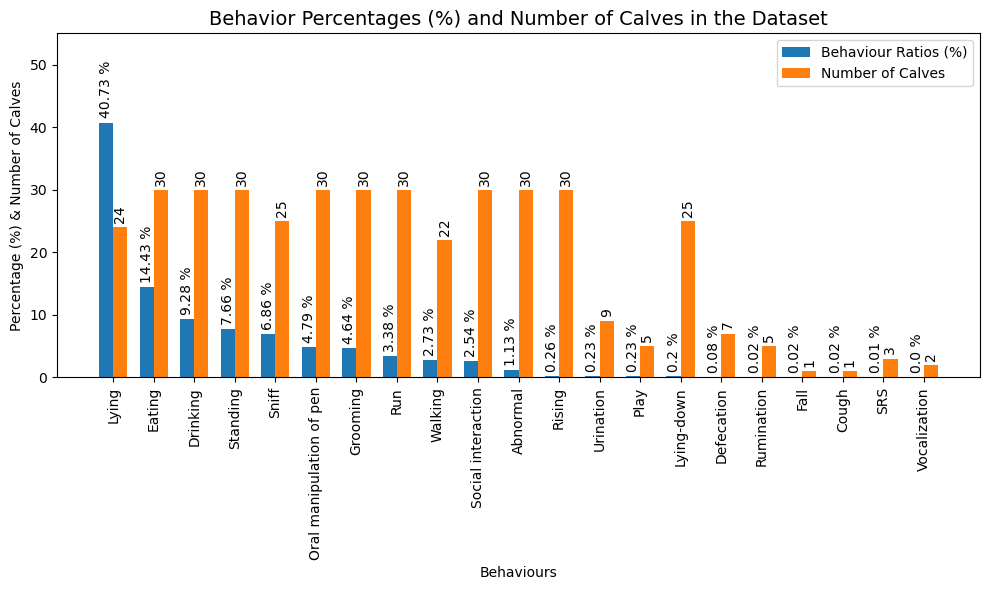

In [132]:
import numpy as np

plt.rcParams['figure.figsize'] = (15,10)

# Extracting keys and values
keys = list(behav_ratios.keys())
values_behav_ratios = list(behav_ratios.values())
values_no_of_calves = list(no_of_calves.values())

x = np.arange(len(keys))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, values_behav_ratios, width, label='Behaviour Ratios (%)')
rects2 = ax.bar(x + width/2, values_no_of_calves, width, label='Number of Calves')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Behaviours')
ax.set_ylabel('Percentage (%) & Number of Calves')
ax.set_title('Behavior Percentages (%) and Number of Calves in the Dataset', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(keys, rotation=90)
ax.legend()

# Function to add the bar heights on top of the bars
def autolabel_percentage(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height} %',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)
        
def autolabel_no_of_calves(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

autolabel_percentage(rects1)
autolabel_no_of_calves(rects2)

plt.ylim(0,55)
# plt.grid()

fig.tight_layout()

plt.show()

# windowing

In [6]:
# calf_ids
calf_ids = dataset_df.calfId.unique()

In [7]:
# windowing params
window_duration = 3
data_frequency = 25
min_window_size = 0.95
overlap = 0.5
datetime_column_name = 'dateTime'

In [8]:
%%time

window_dataset = {}
for calf_id in calf_ids:
    window_dataset[calf_id] = {}
    calf_df = dataset_df[dataset_df.calfId == calf_id]
    
    for segment in calf_df.segId.unique():
        df_sub = calf_df[calf_df.segId == segment]
        df_sub = df_sub.reset_index(drop=True)
        label = df_sub.behaviour[0]

        # error handling
        if len(df_sub.behaviour.unique()) > 1:
            print(f'Error for segment {segment} : Multiple behaviours detected.')
            break

        if label not in window_dataset[calf_id]:
            window_dataset[calf_id][label] = []

        windows = windowing.return_windows(df_sub, 
                                           window_duration=window_duration, 
                                           data_frequency=data_frequency, 
                                           min_window_size=min_window_size, 
                                           overlap=overlap, 
                                           datetime_column_name=datetime_column_name)
        
        window_dataset[calf_id][label].extend(windows)

CPU times: user 46.9 s, sys: 341 ms, total: 47.3 s
Wall time: 47.1 s


In [9]:
with open('Datasets/window_dataset_v1.pickle', 'wb') as handle:
    pickle.dump(window_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Explanation